## Track Lyrics Sentiment Analysis
While cleaning the data and dropping the duplicates, it became apparent that the lyrical data collected was made of several languages such as spanish or german. After performing some research on multilingual sentiment analysis, it was concluded that the sentiment analysis process is exactly the same for any other language as it were for english. However, some preprocessing to classify the languages is required in order to specify the language of choice to the text processing library. 

To begin the process, the language for each lyrics is identified using a language classification library. Since the library used for processing the lyrics does not support all the languages that were identified, only lyrics whose languages are supported are pulled from the dataframe to make the process more efficient. The reason the unsupported lyrics are not translated instead is firstly because the analysis focuses on the actual original language of the song and secondly the language translation tools can be inaccurate when dealing with non-formal variation of a language (slang) which is used a lot in music.

### Imports

In [747]:
import pandas as pd
import numpy as np
import re
import swifter #used to make pd.apply more efficient
from langid.langid import LanguageIdentifier, model # used to analyze the language that the song is in
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from textblob import TextBlob

First the csv containing the data is read and displayed in order to ensure that the dataframe is correctly being read and the attributes correct.

In [299]:
tracks_df = pd.read_csv('/Users/mariamtamer/VSCodeProjects/lyricalanalysis/data/all_tracks_cleaned.csv')

In [300]:
tracks_df.head()

,track_uri,track_name,cleaned_track_name,track_artists,featured_artists,track_is_explicit,track_popularity,track_genres,track_duration_ms,track_time_signature,...,track_valence,track_lyrics,lyrics_page_views,track_number,album_name,album_artist,album_release_date,album_popularity,album_record_label,album_cover
0,spotify:track:2HSmyk2qMN8WQjuGhaQgCk,Champagne Poetry,Champagne Poetry,"('Drake',)",NaN,True,82,"('hip hop', 'pop', 'rap')",336511,4.0,...,0.496,"Champagne Poetry Lyrics\n\nI love you, I love ...",688853.0,1,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
1,spotify:track:6jy9yJfgCsMHdu2Oz4BGKX,Papi’s Home,Papi’s Home,"('Drake',)",NaN,True,76,"('hip hop', 'pop', 'rap')",178623,4.0,...,0.588,Papi’s Home Lyrics\nI know that I hurt you\nYe...,445883.0,2,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
2,spotify:track:37Nqx7iavZpotJSDXZWbJ3,Girls Want Girls (with Lil Baby),NaN,"('Drake', 'Lil Baby')",NaN,True,86,"('hip hop', 'pop', 'rap', 'trap')",221979,4.0,...,0.381,NaN,NaN,3,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
3,spotify:track:61S79KIVA4I9FXbnsylEHT,In The Bible (with Lil Durk & Giveon),In The Bible,"('Drake', 'Lil Durk', 'Giveon')","('GIVĒON', 'Lil Durk')",True,79,"('hip hop', 'pop', 'rap', 'drill', 'trap', 'r&b')",296568,4.0,...,0.147,"In The Bible Lyrics\nOkay, okay, okay\nCountin...",439186.0,4,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
4,spotify:track:4VCbgIdr8ptegWeJpqLVHH,Love All (with JAY-Z),NaN,"('Drake', 'JAY-Z')",NaN,True,77,"('hip hop', 'pop', 'rap')",228461,4.0,...,0.155,NaN,NaN,5,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...


## Data Pre-Processing for Lyrics



### Language Identification

Given the large amount of data collected, the lyrics collected include several langauges. This being said, the sentiment analysis will depend on the language of the lyrics, thus, it is important to tackle multilingual lyrics. There are several approaches to be considered to handle multilingual data:
1. Translating the Lyrics to English then Performing a Sentiment Analysis
2. Using only English Lyrics
3. Splitting the Data by Language and Tackling Each Language Individually

While option 1 is ideal for maintaining the full dataframe, it is not at all the best option given the fact that translation tools are not accurate and the analysis would not be representation of the actual words used since translations would result in a higher word count for certain words.

To determine between options 2 and 3, the count of each languages needs to be identified in order to identify how much of the data will be lost in the case of picking  either option. To begin this process, the language of the song is identified using the following function, which takes each lyric and classifies its lyrics using lang_identify.classify() from the langid library. A list of all the unique languages is made in order to make the process of cleaning easier.

In [303]:
languages = []
lang_identify = LanguageIdentifier.from_modelstring(model, norm_probs=True)
def detect_language(lyrics):
    #print(lyrics)
    if np.any(pd.notna(lyrics)):
        lang = lang_identify.classify(lyrics)
    else:
        lang = np.nan
        
    if lang == np.nan:
        return lang
    else: 
        if type(lang) == float:
            return np.nan
        else:
            if lang[0] not in languages:
                languages.append(lang[0])
            return lang[0]
        

The function is applied to the dataframe with the help of the swifter library which utilizes multithreading to speedup the process. The list of all the unique identified languages is printed.

In [305]:
lang_detected = tracks_df.swifter.apply(lambda x: detect_language(x.track_lyrics), axis=1)
#tc = textcat.TextCat()
#print(tracks_df['track_lyrics'][0:10].apply(tc.guess_language))
#tracks_df[0:10].apply(lambda x: tc.guess_language(x.track_lyrics) if(np.all(pd.notna(x))) else x, axis=1).head
print(languages)

Pandas Apply: 100%|██████████| 156480/156480 [05:16<00:00, 494.10it/s] 

['en', 'ko', 'ja', 'es', 'pt', 'id', 'de', 'it', 'fr', 'zh', 'da', 'ga', 'br', 'nn', 'la', 'fa', 'sw', 'cy', 'fi', 'hu', 'tl', 'lb', 'lv', 'af', 'ms', 'an', 'is', 'zu', 'nl', 'mg', 'cs', 'ur', 'et', 'jv', 'oc', 'sv', 'se', 'ru', 'gl', 'pl', 'mt', 'fo', 'el', 'he', 'rw', 'ky', 'tr', 'hi', 'no', 'qu', 'lt', 'eo', 'ca', 'ps']


Next a new column is created and inserted into the dataframe to represent the language lyrics.

In [306]:
tracks_df.insert(4, 'lyrics_language', lang_detected)
tracks_df

,track_uri,track_name,cleaned_track_name,track_artists,lyrics_language,featured_artists,track_is_explicit,track_popularity,track_genres,track_duration_ms,...,track_valence,track_lyrics,lyrics_page_views,track_number,album_name,album_artist,album_release_date,album_popularity,album_record_label,album_cover
0,spotify:track:2HSmyk2qMN8WQjuGhaQgCk,Champagne Poetry,Champagne Poetry,"('Drake',)",en,NaN,True,82,"('hip hop', 'pop', 'rap')",336511,...,0.496,"Champagne Poetry Lyrics\n\nI love you, I love ...",688853.0,1,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
1,spotify:track:6jy9yJfgCsMHdu2Oz4BGKX,Papi’s Home,Papi’s Home,"('Drake',)",en,NaN,True,76,"('hip hop', 'pop', 'rap')",178623,...,0.588,Papi’s Home Lyrics\nI know that I hurt you\nYe...,445883.0,2,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
2,spotify:track:37Nqx7iavZpotJSDXZWbJ3,Girls Want Girls (with Lil Baby),NaN,"('Drake', 'Lil Baby')",NaN,NaN,True,86,"('hip hop', 'pop', 'rap', 'trap')",221979,...,0.381,NaN,NaN,3,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
3,spotify:track:61S79KIVA4I9FXbnsylEHT,In The Bible (with Lil Durk & Giveon),In The Bible,"('Drake', 'Lil Durk', 'Giveon')",en,"('GIVĒON', 'Lil Durk')",True,79,"('hip hop', 'pop', 'rap', 'drill', 'trap', 'r&b')",296568,...,0.147,"In The Bible Lyrics\nOkay, okay, okay\nCountin...",439186.0,4,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
4,spotify:track:4VCbgIdr8ptegWeJpqLVHH,Love All (with JAY-Z),NaN,"('Drake', 'JAY-Z')",NaN,NaN,True,77,"('hip hop', 'pop', 'rap')",228461,...,0.155,NaN,NaN,5,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156475,spotify:track:0VxTtE5HoNMf9sp30j6c9V,Try Again,NaN,"('Westlife',)",NaN,NaN,False,47,"('boy band', 'dance pop', 'europop')",214866,...,0.381,NaN,NaN,14,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...
156476,spotify:track:3EHx4H0FsTplZrcFSeuLeE,What I Want Is What I Got,What I Want Is What I’ve Got,"('Westlife',)",en,NaN,False,46,"('boy band', 'dance pop', 'europop')",213066,...,0.744,What I Want Is What I’ve Got Lyrics\nAll that ...,NaN,15,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...
156477,spotify:track:4GfGx2zvY8pIwf2o2SAufU,We Are One,NaN,"('Westlife',)",NaN,NaN,False,45,"('boy band', 'dance pop', 'europop')",222893,...,0.426,NaN,NaN,16,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...
156478,spotify:track:7dODnrD8danC9FD5xLb9Tu,Can't Lose What You Never Had,Can’t Lose What You Never Had,"('Westlife',)",en,NaN,False,45,"('boy band', 'dance pop', 'europop')",264485,...,0.656,Can’t Lose What You Never Had Lyrics\nBaby you...,6644.0,17,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...


Now, the count of each of the languages detected can be identified.

In [307]:
tracks_df.lyrics_language.value_counts()

en    70641
es     8680
de     1149
fr     1056
pt      968
ko      604
it      144
ja      130
la      104
id       54
sw       44
zh       29
sv       24
br       21
gl       21
ga       20
an       17
qu       17
tl       16
jv       12
lb       12
af       10
nl       10
da        9
tr        8
cy        8
ms        7
mg        7
lv        7
hi        7
mt        6
et        5
oc        5
ky        4
fi        4
ru        4
eo        3
ps        3
se        2
pl        2
ur        2
he        2
zu        2
hu        2
nn        2
fo        1
el        1
rw        1
is        1
no        1
fa        1
lt        1
ca        1
cs        1
Name: lyrics_language, dtype: int64

As seen above, English (en) makes up the majority of the lyrics identified, making up about 84% out of 83,893 lyrics. That means that option 2 would lead to about 16% loss of data which is not significant given the large dataset collected. However, option 3 can further be examined to identify whether or not it will result in a better and more inclusive analysis. It should be noted that the language detection is not accurate on shorter text as there aren't many words to compare against, so removing the lyrics whose languages have a count of less than 20 is necessary as most where detected inaccurately as identified after closer examination.

Thus, the languages supported by the stopwords, stemmer, and sentiment libraries are analyzed before proceeding to identify the results of the 3rd option.

In [308]:
from nltk.corpus import stopwords
print(stopwords.fileids())

#['en', 'es', 'pt', 'fr', 'de', 'it', 'id', 'sv] 

['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Seeing the languages supported by the stopwords (as above), stemmer, lemmastizer, and sentiment (after some research), the following dictionary maps the language abbreviations to their actual names as identified by the libraries stated. Only 5 languages from the total of 56 languages identified are supported, reaping only about a 2.6% loss which is significant when compared to the results of option 2. Thus, option 3 will be the option of choice adopted for this analysis.

In [309]:
language_short_name = {'de':'german', 'en':'english','fr':'french', 'it':'italian', 'es':'spanish'} #'pt':'portuguese','sv':'swedish'

A new dataframe is defined extracting the languages used for the analysis.

In [551]:
extracted_df = tracks_df.loc[(tracks_df['lyrics_language'] == 'en') | (tracks_df['lyrics_language'] == 'es') | (tracks_df['lyrics_language'] == 'de') | (tracks_df['lyrics_language'] == 'fr') | (tracks_df['lyrics_language'] == 'it')] #| (tracks_df['lyrics_language'] == 'pt') | (tracks_df['lyrics_language'] == 'sv')
extracted_df

,track_uri,track_name,cleaned_track_name,track_artists,lyrics_language,featured_artists,track_is_explicit,track_popularity,track_genres,track_duration_ms,...,track_valence,track_lyrics,lyrics_page_views,track_number,album_name,album_artist,album_release_date,album_popularity,album_record_label,album_cover
0,spotify:track:2HSmyk2qMN8WQjuGhaQgCk,Champagne Poetry,Champagne Poetry,"('Drake',)",en,NaN,True,82,"('hip hop', 'pop', 'rap')",336511,...,0.4960,"Champagne Poetry Lyrics\n\nI love you, I love ...",688853.0,1,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
1,spotify:track:6jy9yJfgCsMHdu2Oz4BGKX,Papi’s Home,Papi’s Home,"('Drake',)",en,NaN,True,76,"('hip hop', 'pop', 'rap')",178623,...,0.5880,Papi’s Home Lyrics\nI know that I hurt you\nYe...,445883.0,2,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
3,spotify:track:61S79KIVA4I9FXbnsylEHT,In The Bible (with Lil Durk & Giveon),In The Bible,"('Drake', 'Lil Durk', 'Giveon')",en,"('GIVĒON', 'Lil Durk')",True,79,"('hip hop', 'pop', 'rap', 'drill', 'trap', 'r&b')",296568,...,0.1470,"In The Bible Lyrics\nOkay, okay, okay\nCountin...",439186.0,4,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
7,spotify:track:4s7QLoImIwmPi9L6dq1nVW,TSU,TSU,"('Drake',)",en,NaN,True,78,"('hip hop', 'pop', 'rap')",308755,...,0.2460,"TSU Lyrics\nYeah, we back\nWhat's up, ladies?\...",763184.0,8,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
8,spotify:track:34D6FJysnQioVingDKufuf,N 2 Deep,N 2 Deep,"('Drake', 'Future')",en,"('Future',)",True,76,"('hip hop', 'pop', 'rap', 'pop rap', 'trap')",273577,...,0.0744,"N 2 Deep Lyrics\n\nOh yeah, yeah\nKept the Gal...",455461.0,9,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156473,spotify:track:4DdXHK3z3vb7kPNIisCp3K,More than Words,More Than Words,"('Westlife',)",en,NaN,False,63,"('boy band', 'dance pop', 'europop')",234840,...,0.5390,More Than Words Lyrics\nSaying I love you\nIs ...,16507.0,12,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...
156474,spotify:track:1KVhwSjfkQLKpfHYbHfZOm,Open Your Heart,Open Your Heart,"('Westlife',)",en,NaN,False,50,"('boy band', 'dance pop', 'europop')",218933,...,0.2580,Open Your Heart Lyrics\nI didn't mean to let y...,NaN,13,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...
156476,spotify:track:3EHx4H0FsTplZrcFSeuLeE,What I Want Is What I Got,What I Want Is What I’ve Got,"('Westlife',)",en,NaN,False,46,"('boy band', 'dance pop', 'europop')",213066,...,0.7440,What I Want Is What I’ve Got Lyrics\nAll that ...,NaN,15,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...
156478,spotify:track:7dODnrD8danC9FD5xLb9Tu,Can't Lose What You Never Had,Can’t Lose What You Never Had,"('Westlife',)",en,NaN,False,45,"('boy band', 'dance pop', 'europop')",264485,...,0.6560,Can’t Lose What You Never Had Lyrics\nBaby you...,6644.0,17,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...


In [552]:
extracted_df.lyrics_language.value_counts()

en    70641
es     8680
de     1149
fr     1056
it      144
Name: lyrics_language, dtype: int64

### Lowercasing
Preprocessing and normalizing the text is a crucial step before beginning to analyze and calculate sentiment scores for the lyrics. This is because it maintains a uniform state for words. 

In [553]:
extracted_df['track_lyrics'][1053] # before lowercasing

"Be Alright (Acoustic Version) LyricsI miss you\nAcross the ocean, across the sea\nStarting to forget the way you look at me now\nOver the mountains, across the sky\nNeed to see your face, I need to look in your eyes\nThrough the storm and through the clouds\nBumps on the road and we're upside down\nI know it's hard, babe, to sleep at night\nDon't you worry\n'Cause everything's gonna be alright, ai-ai-ai-aight\nBe alright, ai-ai-ai-aight\nThrough the long nights\nAnd the bright lights\nDon't you worry\n'Cause everything's gonna be alright, ai-ai-ai-aight\nBe alright, ai-ai-ai-aight\nThrough the long nights\nAnd the bright lights\nDon't you worry\n'Cause everything's gonna be alright, ai-ai-ai-aight\nBe alright, ai-ai-ai-aight\nAll alone, in my room..\nWaiting for your phone call to come soon\nAnd for you, oh, I would walk a thousand miles\nTo be in your arms, holding my heart\nOh I\nOh I\n(Oh I)\nLove you\nAnd everything's gonna be alright, ai-ai-ai-aight\nBe alright, ai-ai-ai-aight\nY

In [554]:
extracted_df['track_lyrics'] = extracted_df['track_lyrics'].apply(lambda x: "\n".join(x.lower() for x in x.split('\n')))

In [555]:
extracted_df['track_lyrics'][1053] # after lowercasing

"be alright (acoustic version) lyricsi miss you\nacross the ocean, across the sea\nstarting to forget the way you look at me now\nover the mountains, across the sky\nneed to see your face, i need to look in your eyes\nthrough the storm and through the clouds\nbumps on the road and we're upside down\ni know it's hard, babe, to sleep at night\ndon't you worry\n'cause everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nthrough the long nights\nand the bright lights\ndon't you worry\n'cause everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nthrough the long nights\nand the bright lights\ndon't you worry\n'cause everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nall alone, in my room..\nwaiting for your phone call to come soon\nand for you, oh, i would walk a thousand miles\nto be in your arms, holding my heart\noh i\noh i\n(oh i)\nlove you\nand everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\ny

### Removing the First Line of Lyrics
The Genius API returns the name of the song as part of the lyrics in the song. This is unnecessary for the analysis so needs to be removed. The following function checks for the word 'lyrics' in the first line of the lyrics and returns everything after the word.

In [556]:
def remove_first_line(text):
    x = text.find('\n')
    find = text.find('lyrics', 0, x)
    if find != -1:
        return text[find+6:]
    else:
        return text

In [557]:
extracted_df['track_lyrics'] = extracted_df['track_lyrics'].apply(lambda x: remove_first_line(x))

In [558]:
extracted_df['track_lyrics'][1053] # after first line removal

"i miss you\nacross the ocean, across the sea\nstarting to forget the way you look at me now\nover the mountains, across the sky\nneed to see your face, i need to look in your eyes\nthrough the storm and through the clouds\nbumps on the road and we're upside down\ni know it's hard, babe, to sleep at night\ndon't you worry\n'cause everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nthrough the long nights\nand the bright lights\ndon't you worry\n'cause everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nthrough the long nights\nand the bright lights\ndon't you worry\n'cause everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nall alone, in my room..\nwaiting for your phone call to come soon\nand for you, oh, i would walk a thousand miles\nto be in your arms, holding my heart\noh i\noh i\n(oh i)\nlove you\nand everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nyou know that i care for you\ni'll al

### Removing the Embed Word at the End of the Lyrics
The Genius API returns an embed word at the end of every lyric as part of the lyrics in the song. This again is unnecessary for the analysis so needs to be removed. The following function checks for the word 'embed' in the last line of the lyrics and returns everything before the word.

In [559]:
def remove_last_word(text):
    x = text.rfind('\n')
    find = text.rfind('embed', x)
    if find != -1:
        return text[:find]
    else:
        return text

In [560]:
extracted_df['track_lyrics'] = extracted_df['track_lyrics'].apply(lambda x: remove_last_word(x))

In [561]:
extracted_df['track_lyrics'][1053] # after 'embed' removal

"i miss you\nacross the ocean, across the sea\nstarting to forget the way you look at me now\nover the mountains, across the sky\nneed to see your face, i need to look in your eyes\nthrough the storm and through the clouds\nbumps on the road and we're upside down\ni know it's hard, babe, to sleep at night\ndon't you worry\n'cause everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nthrough the long nights\nand the bright lights\ndon't you worry\n'cause everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nthrough the long nights\nand the bright lights\ndon't you worry\n'cause everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nall alone, in my room..\nwaiting for your phone call to come soon\nand for you, oh, i would walk a thousand miles\nto be in your arms, holding my heart\noh i\noh i\n(oh i)\nlove you\nand everything's gonna be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nyou know that i care for you\ni'll al

### Normalizing Contractions

It is known that the English langauge has some contractions such as won't, gonna, i'll, which are commonly used in lyrics. These contractions can cause some problems when it comes to text normalization and standardization, hence it is good practice to get rid of them before further text cleaning. I came across this [gist](https://gist.github.com/nealrs/96342d8231b75cf4bb82) which defined a function to expand contractions using a very handy dictionary of some commonly used contractions as well as some non-commonly used ones. I have added the words 'gonna', 'wanna', 'i'mma', and 'i'ma' since they are commonly used in the lyrics. This expansion might not be grammarly correct, however isn't going to affect the analysis as it composes of only dealing with the frequency of

As for other languages, contractions may be common however it is difficult to identify the common contractions as the support for the other languages is not widely available and there are several contractions can have different meanings in different context. Additionally, most contractions in languages such as french or german are prepositions or pronouns which do not have a huge contribution to sentiment analysis (as opposed to english contractions which shorten verbs) as they are generally considered neutral. Hence, for the purpose of the analysis contractions for othet languages will not be considered and this can be an extension to the analysis.

In [562]:
contractions_list = {
  "ain't": "am not", "aren't": "are not", "can't": "can not", "can't've": "cannot have", "'cause": "because", "could've": "could have", 
  "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "gonna": "going to", 
  "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
  "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
  "how's": "how is", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'ma": "i am going to", 
  "i'mma": "i am going to", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it had", "it'd've": "it would have", "it'll": "it will", 
  "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", 
  "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
  "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
  "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
  "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
  "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there had", 
  "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
  "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wanna": "want to", "wasn't": "was not", 
  "we'd": "we had", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
  "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", 
  "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
  "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
  "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
  "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", 
  "y'all've": "you all have", "you'd": "you had", "you'd've": "you would have", "you'll": "you you will", "you'll've": "you you will have", 
  "you're": "you are", "you've": "you have", "'s": " is"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions_list.keys()))

def decontract_lyrics(text, contractions_re=contractions_re):
    def replace(match):
        return contractions_list[match.group(0)]
    return contractions_re.sub(replace, text)

In [563]:
extracted_df['track_lyrics'] = extracted_df.apply(lambda x: decontract_lyrics(x.track_lyrics) if x.lyrics_language == 'en' else x.track_lyrics, axis=1)


In [564]:
extracted_df['track_lyrics'][1053] # after decontraction

'i miss you\nacross the ocean, across the sea\nstarting to forget the way you look at me now\nover the mountains, across the sky\nneed to see your face, i need to look in your eyes\nthrough the storm and through the clouds\nbumps on the road and we are upside down\ni know it is hard, babe, to sleep at night\ndo not you worry\nbecause everything is going to be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nthrough the long nights\nand the bright lights\ndo not you worry\nbecause everything is going to be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nthrough the long nights\nand the bright lights\ndo not you worry\nbecause everything is going to be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nall alone, in my room..\nwaiting for your phone call to come soon\nand for you, oh, i would walk a thousand miles\nto be in your arms, holding my heart\noh i\noh i\n(oh i)\nlove you\nand everything is going to be alright, ai-ai-ai-aight\nbe alright, ai-ai-ai-aight\nyou know that

### Removing Special Characters and Numbers

Some lyrics could contain non-numeric and non-alphabetic characters such as {$,()-?}. These characters result in creating their own tokens which can overcomplicate the analysis. Thus, they are removed. Additionally, numbers are insignificant to the sentiment analysis so they are removed as well.

In [565]:
def clean_punc(lyric): #function to clean the word of any punctuation or special characters
    cleaned_lyric = re.sub(r'[?|!|\'|"|#]',r' ',lyric)
    cleaned_lyric = re.sub(r'[.|,|)|(|\|/|_|-]',r' ',cleaned_lyric)
    cleaned_lyric = cleaned_lyric.strip()
    cleaned_lyric = cleaned_lyric.replace("\n"," ")
    return cleaned_lyric

In [566]:
def keep_alphabetic(lyrics): #function to keep only alphabet including accented characters
    alpha_sentence = ""
    for word in lyrics.split():
        alpha_word = re.sub(r'[^\nA-Za-zÀ-ÖØ-öø-ÿЀ-ӿ/]+', '', word)
        alpha_sentence += alpha_word
        alpha_sentence += " "
    alpha_sentence = alpha_sentence.strip()
    return alpha_sentence

In [567]:
extracted_df['track_lyrics'] = extracted_df['track_lyrics'].apply(lambda x: clean_punc(x))
extracted_df['track_lyrics'] = extracted_df['track_lyrics'].apply(lambda x: keep_alphabetic(x))
# extracted_df['track_lyrics'] = extracted_df['track_lyrics'].str.replace('[^\w\s]','')
# extracted_df['track_lyrics'] = extracted_df['track_lyrics'].str.replace('\n', ' ').str.replace("\'", "") # removing \n and \

In [568]:
extracted_df['track_lyrics'][1053] # after special character removal and new line character

'i miss you across the ocean across the sea starting to forget the way you look at me now over the mountains across the sky need to see your face i need to look in your eyes through the storm and through the clouds bumps on the road and we are upside down i know it is hard babe to sleep at night do not you worry because everything is going to be alright ai ai ai aight be alright ai ai ai aight through the long nights and the bright lights do not you worry because everything is going to be alright ai ai ai aight be alright ai ai ai aight through the long nights and the bright lights do not you worry because everything is going to be alright ai ai ai aight be alright ai ai ai aight all alone in my room waiting for your phone call to come soon and for you oh i would walk a thousand miles to be in your arms holding my heart oh i oh i oh i love you and everything is going to be alright ai ai ai aight be alright ai ai ai aight you know that i care for you i will always be there for you i pro

#### Removing Short Lyrics and Empty Lyrics

After all the cleaning that was done, it is likely that some lyrics have become shorter than necessary which will make them insignificant to the analysis. Thus, only strings above 100 characters are taken into account for the analysis and rows not meeting this condition are dropped.

In [569]:
extracted_df.loc[extracted_df['track_lyrics'].str.len() < 101, ['track_lyrics']] = np.nan
extracted_df = extracted_df.dropna(subset=['track_lyrics'])
extracted_df

,track_uri,track_name,cleaned_track_name,track_artists,lyrics_language,featured_artists,track_is_explicit,track_popularity,track_genres,track_duration_ms,...,track_valence,track_lyrics,lyrics_page_views,track_number,album_name,album_artist,album_release_date,album_popularity,album_record_label,album_cover
0,spotify:track:2HSmyk2qMN8WQjuGhaQgCk,Champagne Poetry,Champagne Poetry,"('Drake',)",en,NaN,True,82,"('hip hop', 'pop', 'rap')",336511,...,0.4960,i love you i love you i love you until i until...,688853.0,1,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
1,spotify:track:6jy9yJfgCsMHdu2Oz4BGKX,Papi’s Home,Papi’s Home,"('Drake',)",en,NaN,True,76,"('hip hop', 'pop', 'rap')",178623,...,0.5880,i know that i hurt you yeah i was a child tryi...,445883.0,2,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
3,spotify:track:61S79KIVA4I9FXbnsylEHT,In The Bible (with Lil Durk & Giveon),In The Bible,"('Drake', 'Lil Durk', 'Giveon')",en,"('GIVĒON', 'Lil Durk')",True,79,"('hip hop', 'pop', 'rap', 'drill', 'trap', 'r&b')",296568,...,0.1470,okay okay okay countin up my bodies damn the t...,439186.0,4,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
7,spotify:track:4s7QLoImIwmPi9L6dq1nVW,TSU,TSU,"('Drake',)",en,NaN,True,78,"('hip hop', 'pop', 'rap')",308755,...,0.2460,yeah we back what is up ladies swishahouse bab...,763184.0,8,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
8,spotify:track:34D6FJysnQioVingDKufuf,N 2 Deep,N 2 Deep,"('Drake', 'Future')",en,"('Future',)",True,76,"('hip hop', 'pop', 'rap', 'pop rap', 'trap')",273577,...,0.0744,oh yeah yeah kept the galleria open til ten fo...,455461.0,9,Certified Lover Boy,Drake,2021-09-03,95,OVO,https://i.scdn.co/image/ab67616d00001e02cd945b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156473,spotify:track:4DdXHK3z3vb7kPNIisCp3K,More than Words,More Than Words,"('Westlife',)",en,NaN,False,63,"('boy band', 'dance pop', 'europop')",234840,...,0.5390,saying i love you is not the words i want to h...,16507.0,12,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...
156474,spotify:track:1KVhwSjfkQLKpfHYbHfZOm,Open Your Heart,Open Your Heart,"('Westlife',)",en,NaN,False,50,"('boy band', 'dance pop', 'europop')",218933,...,0.2580,i did not mean to let you down you have to bel...,NaN,13,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...
156476,spotify:track:3EHx4H0FsTplZrcFSeuLeE,What I Want Is What I Got,What I Want Is What I’ve Got,"('Westlife',)",en,NaN,False,46,"('boy band', 'dance pop', 'europop')",213066,...,0.7440,all that i want in my life is the feeling of p...,NaN,15,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...
156478,spotify:track:7dODnrD8danC9FD5xLb9Tu,Can't Lose What You Never Had,Can’t Lose What You Never Had,"('Westlife',)",en,NaN,False,45,"('boy band', 'dance pop', 'europop')",264485,...,0.6560,baby you are so beautiful and when i am near y...,6644.0,17,Westlife,Westlife,1999-11-01,73,RCA Records Label,https://i.scdn.co/image/ab67616d00001e0244ead2...


### Standardizing Signal Words

In order to perform bag of word analyses, which focuses on getting the frequency of all the 'signal' words in the specified text or in other words, those that have a significance on the meaning or depiction of the presented text. In most languages, a word can take several forms depending on its placement in a sentence or the context. For instance, the word 'think' can take the forms: 'thought', 'thinking', and 'thinks', each of which mean think and would fall under the same group in the bag-of-words. Hence, these words need to be standardized in order to get a more accurate bag of word analyses.

Another factor to consider would be words that add no significance to the meaning of the sentence such as pronouns or prepositions. Such words are called stop words which also need to be removed for the bag of words analyses.

#### Removing Stop Words

The following function calls the appropriate list of stop words that need to be removed from the lyrics based on the language of lyrics and returns the lyrics stopword-free.

In [570]:
def remove_stopwords(lyrics, language):
    stop = stopwords.words(language_short_name.get(language))
    return  " ".join(lyric for lyric in lyrics.split() if lyric not in stop)

In [571]:
pd.options.mode.chained_assignment = None
extracted_df['track_lyrics'] = extracted_df.swifter.apply(lambda x: remove_stopwords(x.track_lyrics, x.lyrics_language), axis=1)

Pandas Apply: 100%|██████████| 81307/81307 [01:52<00:00, 725.47it/s] 


In [572]:
extracted_df['track_lyrics'][1053] # after stop word removal

'miss across ocean across sea starting forget way look mountains across sky need see face need look eyes storm clouds bumps road upside know hard babe sleep night worry everything going alright ai ai ai aight alright ai ai ai aight long nights bright lights worry everything going alright ai ai ai aight alright ai ai ai aight long nights bright lights worry everything going alright ai ai ai aight alright ai ai ai aight alone room waiting phone call come soon oh would walk thousand miles arms holding heart oh oh oh love everything going alright ai ai ai aight alright ai ai ai aight know care always promise stay right yeah know want baby make anything everything going alright ai ai ai aight alright ai ai ai aight long lights bright lights worry everything going alright ai ai ai aight alright ai ai ai aight long lights bright lights worry everything going alright'

In [573]:
extracted_df['track_lyrics'][453] # after stop word removal

'eh eh encanta levanta jodío eh nunca va lado eh eh cela to oh jode to oh pelea to to vece soporto cuarto damo to arreglamo to cela to to jode to to pelea to to vece soporto cuarto damo to arreglamo to oh aunque vece mal porto espera casa vestidito corto trépate cama pronto quítate to quiero recorrer cuerpo loco ve ojos toco dime ma hago ninguna má ah ah conocí perreando recuérdate do éramo chamaco sonando yandel bailándome besándote nunca solté cela to to jode to to pelea to to veces soporto cuarto damos to arreglamo to oh ey ey conocí bailando perreando rakatá eh eh bien suelta desacatá miró dije échate pa acá dijo papi vente detrá tra años mese eh hemo chingao mil vece todavía hace erice piel eh gusta hable mano eliel huh quisiera to luna miel eh hoy peleando ayer porto bien perro fiel ey ey conmigo pesar desbalance psicológico conmigo importar económico ríe chiste aunque cómico única saca lado romántico caso aunque católico si va má allá acto simbólico ere estrella mami fanático bo

#### Stemming

Stemming referes to a crucial algorithm in text mining algorithm which removes suffixes such as -ing, -es, -ies, and -ed from the words in order to reduce words with a common root to the same form.

In [541]:
def language_stemmer(lyrics, language):
    st = SnowballStemmer(language_short_name.get(language))
    return  " ".join([st.stem(word) for word in lyrics.split()])

In [545]:
extracted_df['track_lyrics'] = extracted_df.swifter.apply(lambda x: language_stemmer(x.track_lyrics, x.lyrics_language), axis=1)

Pandas Apply: 100%|██████████| 82293/82293 [05:04<00:00, 269.94it/s]


In [546]:
extracted_df['track_lyrics'][1053] # after stemming

'miss across ocean across sea start forget way look mountain across sky need see face need look eye storm cloud bump road upsid know hard babe sleep night worri everyth go alright ai ai ai aight alright ai ai ai aight long night bright light worri everyth go alright ai ai ai aight alright ai ai ai aight long night bright light worri everyth go alright ai ai ai aight alright ai ai ai aight alon room wait phone call come soon oh would walk thousand mile arm hold heart oh oh oh love everyth go alright ai ai ai aight alright ai ai ai aight know care alway promis stay right yeah know want babi make anyth everyth go alright ai ai ai aight alright ai ai ai aight long light bright light worri everyth go alright ai ai ai aight alright ai ai ai aight long light bright light worri everyth go alright'

As can be seen above, the stemming process is not grammatically accurate as it doesn't strip words to their grammatical roots but rather as a standard set of rules that it uses to standardize text. This can be seen in the spelling mistakes present in the sample above. For instance, 'everything', and 'anything' have been stripped down to 'everyth' and 'anyth' respectively, which isn't very representative of the actual word.

#### Lemmastization

To address the issue mentioned above, a more sophisticated approach called lemmastization can be used. This approach takes into consideration the part of speech of the language, i.e. whether the word is a noun, verb, adjective, adverb, etc. This makes the approach more accurate when it comes to language standardization as the rules are more adjusted to cater for the part of speech the word is in.

In [637]:
import pattern.en as lem_en
import pattern.es as lem_es
import pattern.de as lem_de
import pattern.fr as lem_fr
import pattern.it as lem_it

def language_lemmatizer(lyrics, language):
    if language == 'en':
        lem = lem_en
    elif language == 'es':
        lem = lem_es
    elif language == 'de':
        lem = lem_de
    elif language == 'fr':
        lem = lem_fr
        lyrics = f"{lyrics}"
    else:
        lem = lem_it
    
    retries = 0
    while retries < 5:
        try:
            return " ".join(lem.Sentence(lem.parse(lyrics, lemmata=True)).lemmata)
        except StopIteration as e:
            retries += 1
            continue
        except:
            retries += 1
            continue
    

In [639]:
extracted_df['track_lyrics'] = extracted_df.swifter.apply(lambda x: language_lemmatizer(x.track_lyrics, x.lyrics_language), axis=1)

Pandas Apply: 100%|██████████| 81307/81307 [36:35<00:00, 37.04it/s]  


In [640]:
extracted_df['track_lyrics'][1053] # english after lemmastization

'miss across ocean across sea start forget way look mountain across sky need see face need look eye storm cloud bump road upside know hard babe sleep night worry everything go alright ai ai ai aight alright ai ai ai aight long night bright light worry everything go alright ai ai ai aight alright ai ai ai aight long night bright light worry everything go alright ai ai ai aight alright ai ai ai aight alone room wait phone call come soon oh would walk thousand mile arm hold heart oh oh oh love everything go alright ai ai ai aight alright ai ai ai aight know care always promise stay right yeah know want baby make anything everything go alright ai ai ai aight alright ai ai ai aight long light bright light worry everything go alright ai ai ai aight alright ai ai ai aight long light bright light worry everything go alright'

In [641]:
extracted_df['track_lyrics'][453] # spanish after lemmastization

'eh eh encantar levantar jodío eh nunca ir lado eh eh celar tar oh jode tar oh pelea tar tar vece soporto cuarto damo tar arreglamo tar celar tar tar jode tar tar pelea tar tar vece soporto cuarto damo tar arreglamo tar oh aunque vece mal porto esperar casa vestidito corto trépate cama pronto quítate tar querer recorrer cuerpo loco ver ojo tocar dime mo hacer ninguna má ah ah conocer perreando recuérdate do éramo chamaco sonar yandel bailándome besándote nunca solté celar tar tar jode tar tar pelea tar tar vez soporto cuarto dar tar arreglamo tar oh ey ey conocer bailar perreando rakatá eh eh bien suelto desacatá mirar decir échate pa acá decir papi vente detrá trar año mese eh hemo chingao mil vece todavía hacer erice piel eh gustar hable mano eliel huh querer tar luna miel eh hoy pelear ayer porto bien perro fiel ey ey conmigo pesar desbalance psicológico conmigo importar económico reir chiste aunque cómico único sacar lado romántico caso aunque católico si ir má allá acto simbólico 

In [644]:
extracted_df['track_lyrics'][51768] # german after lemmastization

'fest gehen vorn neu aufgabe gespielt verlorn furcht vorm fall lohnen versuch schatz geben reste zweifeln herzen durchwühlen atem alleine anfühlt nächste berg erklimmen schreien ungewissheit bess weeißen ball gefühle teil sinfonie gedanken gehen wurf team beben mitreißt glück pulsiert nennen leben kopf dreht euphorisiert leben eins versprechen gemeinsam passierts hören ruf geben halten mehr festem grund herz schlagen her luft nervös sticht glitzert gehst kante zusamm flur geist fangen blitze kanal strom wehnden fahnen lohnen nächste berg erklimmen schreien ungewissheit bess weeißen ball gefühle teil sinfonie gedanken gehen wurf team beben mitreißt glück pulsiert nennen leben kopf dreht euphorisiert leben eins versprechen gemeinsam passierts leben eins versprechen gemeinsam passierts'

In [648]:
extracted_df['track_lyrics'][150109] # italian after lemmastization

'na luna mezz u mare mamma m maritare figlia cu te dare mamma pensaca te piglio lu pesciaiolere ire vao ire vena sempa lu pesce mana tenere ce ncappa fantasia te pesculia figghiuzza là lariulà pesce fritt baccalà ueo cumpà no calamare eggio accattà na luna mezz u mare mamma m maritare figlia cu te dare mamma pensaca te piglio lu pulezia ire vao ire vena semp scuppetta mana tenere ce ncappa fantasia te scuppettea figghiuzza là lariulà pesce fritt baccalà ueo cumpà na scuppetta eggio accattà'

In [653]:
extracted_df['track_lyrics'][74331] # french after lemmastization

'regard croiser voir sourire jai peur distance échange phrases voir grandir perdre confiance comment comment faire comprendre comment comment faire décoder falloir apprendre rapprocher monde entier poche oh enfant dire quoi ressembler lessentiel quand remonter dernier fois ensemble avoir regarder ciel oh enfant dire quoi ressembler lessentiel quand remonter dernier fois ensemble avoir regarder ciel yeu rivére tou écran monde parallèle maintenir parler trouver plus temps amour virtuel comment comment faire comprendre comment comment faire décoder falloir apprendre rapprocher monde entier poche oh enfant dire quoi ressembler lessentiel quand remonter dernier fois ensemble avoir regarder ciel oh enfant quoi ressembler lessentiel oh enfant si regarder ciel quand remonter dernier fois ensemble avoir regarder ciel'

It can be seen that this is a much better as the words have been changed to their correct roots and have actual meaning compared to the stemming algorithm. For instance, "anything" and "everything" remain the same without treating them as verbs compared to stemming. Now that the text standardization and normalization is complete, we can move onto the bag-of-words algorithm as well as the sentiment score calculation.

### English Language Lyrical Analysis

As discussed before, the analysis that will be adopted in the sentiment analysis scoring is  by applying the algorithm separately on each language. Thus, a dataframe is created for each of the languages in order to apply the analysis separately for the lyrics and be able to look at comparisons.

To begin, the most common language, English, amounting to over 84% of the lyrics is analyzed in terms of word count data, sentiment scores, and bag of words analysis.

In [658]:
es_df = (extracted_df.loc[(extracted_df['lyrics_language'] == 'es')]).reset_index()
en_df = (extracted_df.loc[(extracted_df['lyrics_language'] == 'en')]).reset_index()
de_df = (extracted_df.loc[(extracted_df['lyrics_language'] == 'de')]).reset_index()
fr_df = (extracted_df.loc[(extracted_df['lyrics_language'] == 'fr')]).reset_index()
it_df = (extracted_df.loc[(extracted_df['lyrics_language'] == 'it')]).reset_index()

##### General Wordcount and Wordcloud Analysis

To get some textual insights, a simple word count analysis of the lyrics can be applied. First the lyrics are split into a list of words.

In [659]:
en_df['words_in_lyrics'] = en_df.track_lyrics.str.strip().str.split('[\W_]+')

In [660]:
en_df['words_in_lyrics']

0        [love, love, love, love, love, love, find, say...
1        [know, hurt, yeah, child, try, man, son, world...
2        [okay, okay, okay, countin, body, damn, thing,...
3        [yeah, back, lady, swishahouse, baby, lady, no...
4        [oh, yeah, yeah, keep, gallerium, open, til, t...
                               ...                        
70336    [say, love, word, want, hear, want, say, know,...
70337    [mean, let, believe, know, go, mind, see, wait...
70338    [want, life, feel, peace, deep, within, truly,...
70339    [baby, beautiful, near, breathe, breathe, girl...
70340    [pretty, girl, around, look, till, view, finde...
Name: words_in_lyrics, Length: 70341, dtype: object

Next, each word is added to a list by iterating through each list for each row in the dataframe. A new dataframe is defined using that list with all the words available.

In [661]:
word_rows = list()
for word_row in en_df[['words_in_lyrics']].iterrows():
    r = word_row[1]
    for word in r.words_in_lyrics:
        word_rows.append((word))

words_in_lyrics_df = pd.DataFrame(word_rows, columns=['word_in_lyrics'])
words_in_lyrics_df.head(10)

,word_in_lyrics
0,love
1,love
2,love
3,love
4,love
5,love
6,find
7,say
8,word
9,know


**Removing Empty Rows**

Although the text was fully cleaned it is still possible that lemmetazition added extra spaces which make up an empty row so needs to be removed from the words.

In [689]:
words_in_lyrics_df = words_in_lyrics_df[words_in_lyrics_df.word_in_lyrics.str.len() > 0]
words_in_lyrics_df['word_in_lyrics'] = words_in_lyrics_df.word_in_lyrics.str.lower()

Next a dataframe can be created retrieving the count of all the unique words in the dataframe to retieve the top twenty words in the english language.

In [692]:
word_counts = words_in_lyrics_df.word_in_lyrics.value_counts().to_frame().rename(columns={'word_in_lyrics':'count'})
top_20_words = word_counts.head(20)
top_20_words

,count
get,257066
go,198050
like,173156
know,170690
yeah,164624
oh,162700
love,145092
want,131223
say,102968
come,91434


The bar plot below helps visualize the top 20 most used words in the English Lyrics. We'll come back to this later when comparing to other languages.

[]

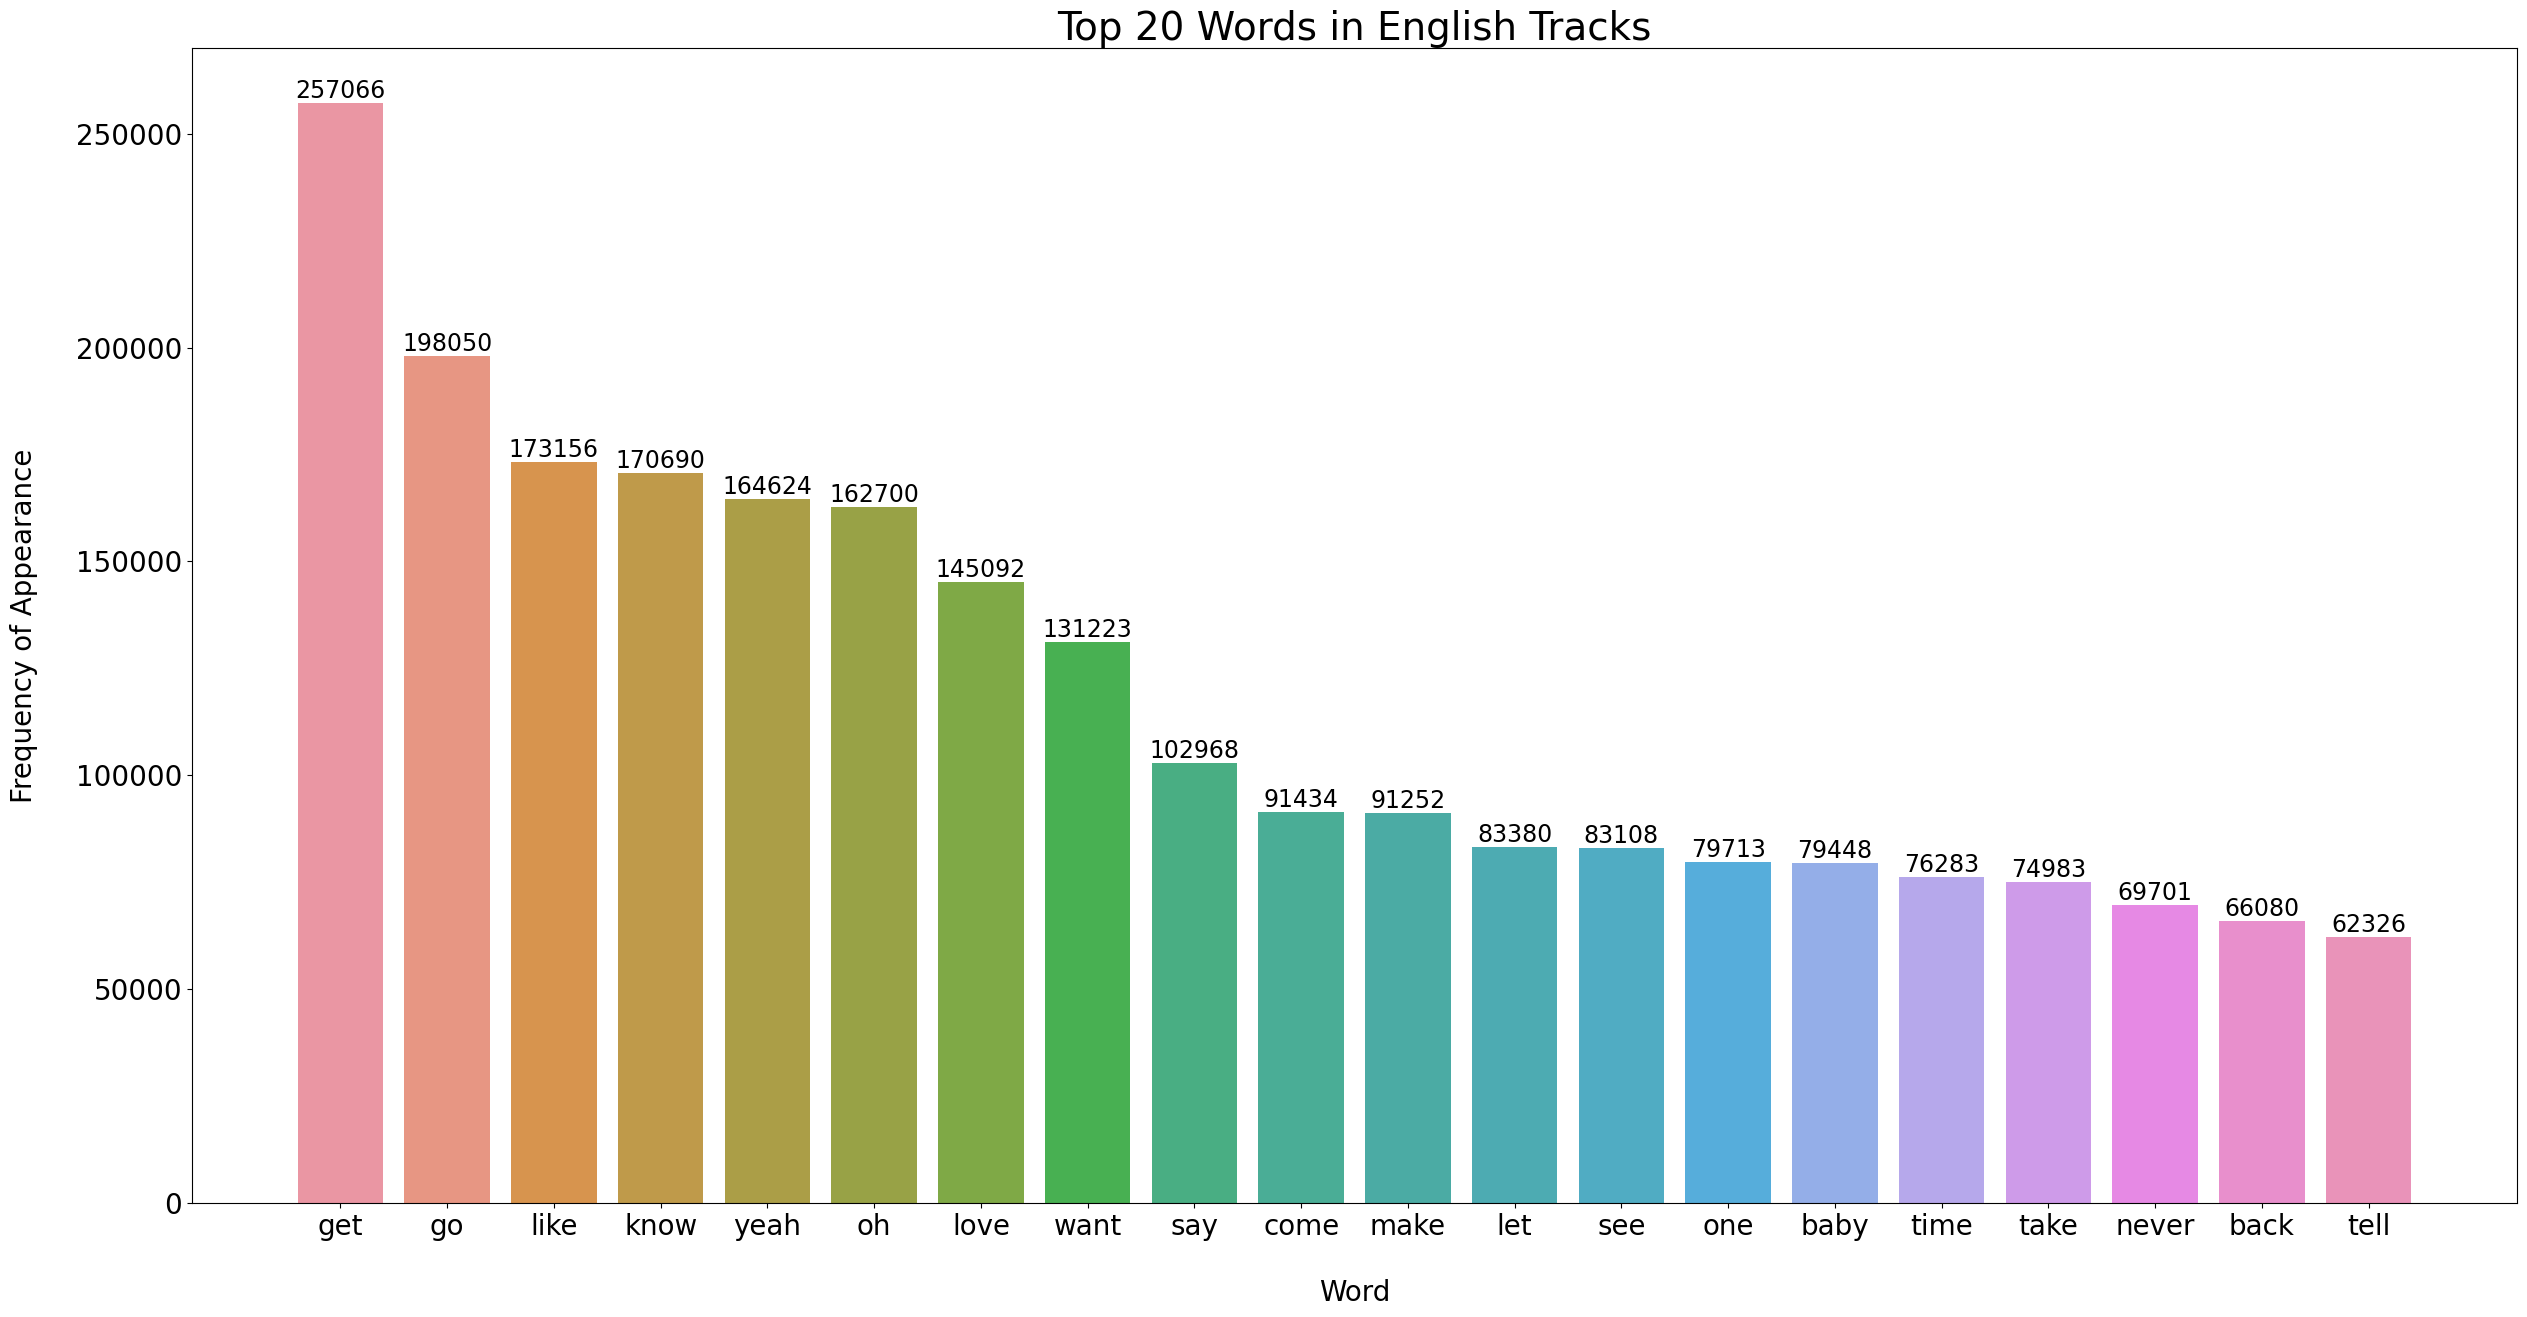

In [856]:
fig, ax = plt.subplots(figsize=(30,15))
ax = seaborn.barplot(x=top_20_words.index, y="count", data=top_20_words)
plt.ylabel('Frequency of Appearance\n', fontsize=20)
plt.xlabel("\nWord", fontsize=20)
plt.title('Top 20 Words in English Tracks', fontsize=28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.bar_label(ax.containers[0], fontsize=17)
plt.plot()

In [829]:
least_20_words = word_counts.tail(20)
least_20_words

To take this analysis a little bit further, we can identify the word count for each song and determine the top songs with the most words count. First the lyrics are tokenized and a new column is created representing the count of those tokens.

In [732]:
en_df['lyrics_tokens'] = pd.Series(dtype=object)
for index, row in en_df.iterrows():
    tokens = word_tokenize(row['track_lyrics'])
    en_df.at[index, 'lyrics_tokens'] = tokens
    en_df.at[index, 'word_count_in_lyrics'] = len(tokens)

Below the top 8 songs with the most used words are presented.

In [733]:
songs_with_more_words = en_df.sort_values("word_count_in_lyrics", ascending=False)
songs_with_more_words[['track_name', 'word_count_in_lyrics']].head(8)

,track_name,word_count_in_lyrics
61436,Mellon Collie And The Infinite Sadness - Home ...,3200.0
61435,Thru The Eyes Of Ruby - Take 7,3200.0
61466,Never Let Me Down Again - BBC Session,3200.0
41278,"Outlaw Blues - Take 1, Complete",2375.0
40827,You're Gonna Make Me Lonesome When You Go - Ta...,2375.0
50719,Mad Flows (feat. Skeme) [Bonus Track],2276.0
61431,Daphne Descends - Mono,2017.0
61432,Crestfallen - Mono,2017.0


To help visualize the word frequency better, a wordcloud is created with the most used words appearing in the lyrics. The following function is used to create the bag of frequent words by keeping a count of each of the words among the songs using their token lists defined earlier.

In [857]:
from collections import Counter

def make_frequency_dictionary(df_column):
    freq_list = []
    for lyric in df_column:
        freq_list.extend(lyric)
    freq_counts = Counter(freq_list)
    return freq_counts
freq_counts_dict = make_frequency_dictionary(en_df.lyrics_tokens)

The following function takes in the counts list that was created earlier and uses the frequency of the word to create a wordcloud.

In [777]:
def create_wordcloud(list_column):
    
    frequency_of_words = {}
    for item in list_column:
        word = item
        frequency_of_words[word] = list_column.get(item)
    
    # set mask image
    mask = np.array(Image.open("/Users/mariamtamer/VSCodeProjects/lyricalanalysis/data/cloud.png"))
    stopwords = set(STOPWORDS)

    wc = WordCloud(
        background_color='white',
        mask=mask,
        max_font_size=100,
        max_words=1000,
        min_word_length=2,
        collocation_threshold= 20,
        stopwords=stopwords,
        repeat=False)
    wc.generate_from_frequencies(frequency_of_words)
    
    return wc

The following plot shows the wordcloud for the most frequenct words in the english lyrics.

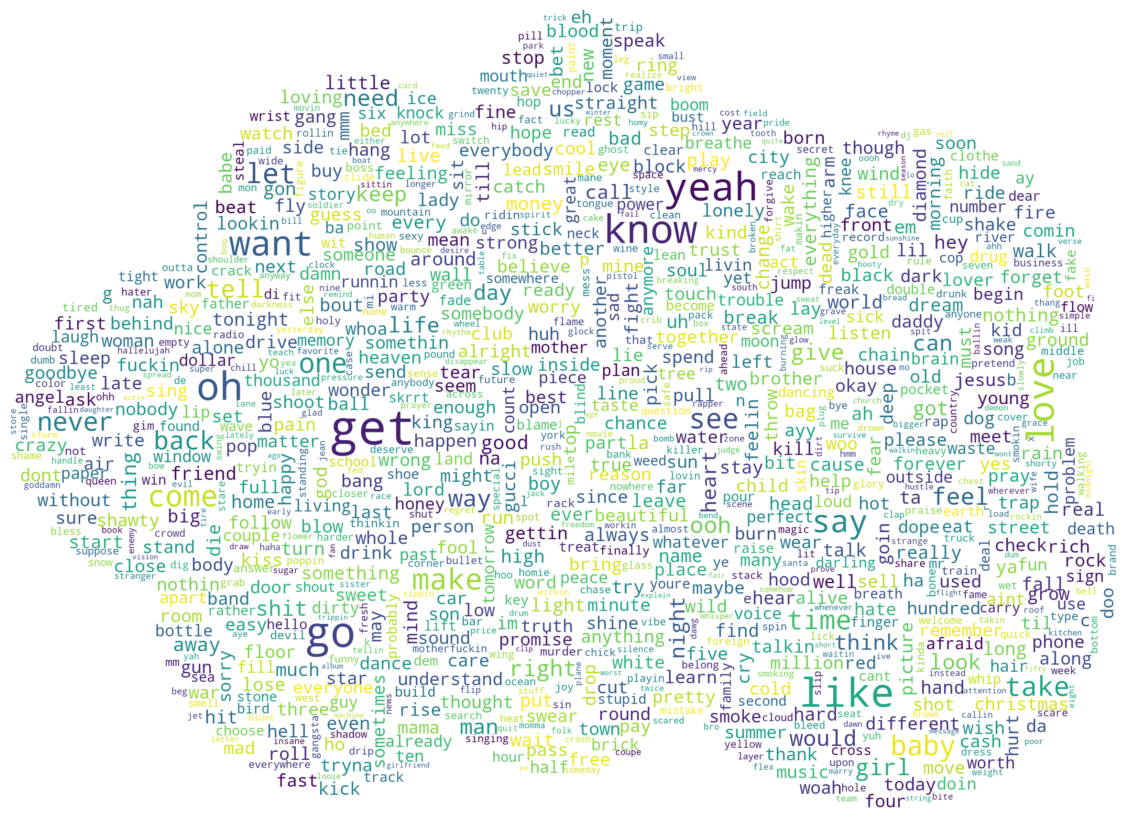

In [779]:
wordcloud = create_wordcloud(freq_counts_dict)
fig = plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation="bilinear")
plt.axis('off')
plt.show()

### Bag of Frequent Words

The following output displays the top 50 most frequent words found in the english tracks and their counts as well as the least 50 frequent words and their counts in the english tracks analysed.

In [866]:
print("Most Frequent Words")
print(list(sorted(freq_counts_dict.items(), key=lambda x: x[1], reverse=True))[0:50])
print("\nLeast Frequent Words")
print(list(sorted(freq_counts_dict.items(), key=lambda x: x[1], reverse=True))[-100:-50])

Most Frequent Words
[('get', 257066), ('go', 198050), ('like', 173156), ('know', 170690), ('yeah', 164624), ('oh', 162700), ('love', 145092), ('want', 131223), ('say', 102968), ('come', 91434), ('make', 91252), ('let', 83380), ('see', 83108), ('one', 79713), ('baby', 79448), ('time', 76283), ('take', 74983), ('never', 69701), ('back', 66080), ('tell', 62326), ('feel', 60374), ('way', 59864), ('nigga', 59846), ('bitch', 58375), ('ooh', 53917), ('girl', 53626), ('need', 52889), ('give', 50441), ('right', 50323), ('can', 48396), ('us', 47774), ('would', 47612), ('shit', 46129), ('fuck', 45948), ('think', 45368), ('man', 45327), ('life', 44688), ('look', 44506), ('keep', 44463), ('day', 43659), ('night', 41199), ('heart', 39606), ('niggas', 38311), ('thing', 37344), ('got', 37302), ('good', 34879), ('away', 34448), ('call', 33667), ('hey', 32725), ('still', 32586)]

Least Frequent Words
[('heartbreakеr', 1), ('routinely', 1), ('moonflower', 1), ('salton', 1), ('forseeing', 1), ('uptake', 1

### Sentiment Analysis of Track Lyrics

Now moving onto the sentiment analysis, there are several libraries that calculate the overall score of a sentence giving it a polarity score to indicate how positive it is. The purpose of this section is to gain insight on whether the lyrics collected are more positive or negative based on the words in those lyrics.

There are two library implementations used below (TextBlob and NLTK Vader) in order to gain a wellrounded analysis of the data and maintain higher accuracy.

##### Using TextBlob

TextBlob is a Lexicon-based sentiment analyzer which has a predefined set of rules for the words and their weights which allow it to determine the polarity of a sentence. The following two functions are used one to first give each lyric a polarity score then the other to determine whether the score value is positive, negative or neutral.

In [868]:
def calculate_sentiment(lyric):
    return TextBlob(lyric).sentiment.polarity

def get_sentiment_value(senti_score):
    if senti_score > 0:
        return 'positive'
    elif senti_score < 0:
        return 'negative'
    else:
        return 'neutral'

The functions are applied on the dataframe to determine the score and get the sentiment value.

In [869]:
en_df['sentiment_polarity_score'] = en_df['track_lyrics'].apply(lambda x: calculate_sentiment(x))
en_df['sentiment_score_value'] = en_df['sentiment_polarity_score'].apply(lambda x: get_sentiment_value(x))

Next, the dataframe will be iterated through to determine the positive, negative and neutral lyric count. Additionally, the lyrics are appended to the positive, negative, and neutral lists based on their scores.

In [880]:
# define count variables
en_positive = 0
en_negative = 0
en_neutral = 0
# define lists
en_lyrics_list = []
en_neutral_list = []
en_negative_list = []
en_positive_list = []

# iterate through the dataframe to get positive, negative, and neutral lyric lists
for i in range(en_df.shape[0]):
    en_lyrics_list.append(en_df['track_lyrics'][i])
    if en_df['sentiment_score_value'][i] == 'positive':
        en_positive_list.append(en_df['track_lyrics'][i])
        en_positive += 1
    elif en_df['sentiment_score_value'][i] == 'negative':
        en_negative_list.append(en_df['track_lyrics'][i])
        en_negative += 1
    else:
        en_neutral_list.append(en_df['track_lyrics'][i])
        en_neutral += 1

Next the percentage of each of the positive negative and neutral lyrics is determined using their count. 

In [881]:
def percentage(part,whole):
    return 100 * float(part)/float(whole)

In [882]:
en_positive = percentage(en_positive, en_df.shape[0])
en_negative = percentage(en_negative, en_df.shape[0])
en_neutral = percentage(en_neutral, en_df.shape[0])
en_positive = format(en_positive, '.2f')
en_negative = format(en_negative, '.2f')
en_neutral = format(en_neutral, '.2f')

The lists defined earlier for the positive, negative and neutral lyrics are turned into dataframes and the count of each is determined as displayed below.

In [883]:
en_lyrics_df = pd.DataFrame(en_lyrics_list)
en_neutral_df = pd.DataFrame(en_neutral_list)
en_negative_df = pd.DataFrame(en_negative_list)
en_positive_df = pd.DataFrame(en_positive_list)
print("total lyrics count: ",len(en_lyrics_df))
print("positive lyrics count: ",len(en_positive_df))
print("negative lyrics count: ", len(en_negative_df))
print("neutral lyrics count: ",len(en_neutral_df))

total lyrics count:  70341
positive lyrics count:  49173
negative lyrics count:  20504
neutral lyrics count:  664


To better visualize the count of the positive, negative and neutral lyrics, a pie chart is created to show the division between each of the categories.

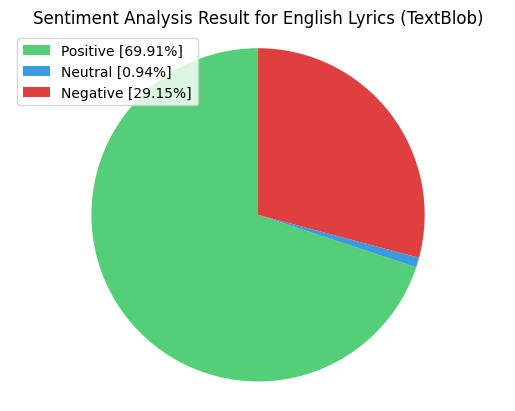

In [884]:
labels = ['Positive ['+str(en_positive)+'%]' , 'Neutral ['+str(en_neutral)+'%]','Negative ['+str(en_negative)+'%]']
sizes = [en_positive, en_neutral, en_negative]
colors = ['#55cf77','#3a9bde','#e03f40']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.setp(ax.spines.values(),visible=False)
if i%2 == 1:
    ax.set_facecolor('white')
plt.title("Sentiment Analysis Result for English Lyrics (TextBlob)" )
plt.axis('equal')
plt.show()

It can be seen that the lyrics giving positive sentiment are a lot more than those giving negative sentiment with rarely any neutral sentiment lyrics. The reason for the rarity of neutral lyrics is the fact that most songs are used to convey an emotion so it makes sense if the emotion is only positive or negative. It must be noted tho that the analysis is only based on the words used in the song and since songs tend to use a lot of figurative language, the analysis is not accurate since an artist could be using a positive word to convey negative feelings and vice versa. It is difficult to determine the context of the songs using this tool since songs are usually open to interpretation and their analyses are often subjective.

##### Using NLTK Vader

In [895]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

en_positive_vader = 0
en_negative_vader = 0
en_neutral_vader = 0
en_lyric_list_vader = []
en_neutral_list_vader = []
en_negative_list_vader = []
en_positive_list_vader = []

for i in range(en_df.shape[0]):
    en_lyric_list_vader.append(en_df.track_lyrics[i])
    score = SentimentIntensityAnalyzer().polarity_scores(en_df.track_lyrics[i])
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
 
    if neg > pos:
        en_negative_list_vader.append(en_df.track_lyrics[i])
        en_negative_vader += 1
    elif pos > neg:
        en_positive_list_vader.append(en_df.track_lyrics[i])
        en_positive_vader += 1
    elif pos == neg:
        en_neutral_list_vader.append(en_df.track_lyrics[i])
        en_neutral_vader += 1

In [886]:
en_positive_vader = percentage(en_positive_vader, en_df.shape[0])
en_negative_vader = percentage(en_negative_vader, en_df.shape[0])
en_neutral_vader = percentage(en_neutral_vader, en_df.shape[0])
en_positive_vader = format(en_positive_vader, '.2f')
en_negative_vader = format(en_negative_vader, '.2f')
en_neutral_vader = format(en_neutral_vader, '.2f')

In [887]:
en_lyric_vader_df = pd.DataFrame(en_lyric_list_vader)
en_neutral_vader_df = pd.DataFrame(en_neutral_list_vader)
en_negative_vader_df = pd.DataFrame(en_negative_list_vader)
en_positive_vader_df = pd.DataFrame(en_positive_list_vader)
print("total number: ",len(en_lyric_vader_df))
print("positive number: ",len(en_positive_vader_df))
print("negative number: ", len(en_negative_vader_df))
print("neutral number: ",len(en_neutral_vader_df))

total number:  70341
positive number:  46710
negative number:  0
neutral number:  23631


In [ ]:
labels = ['Positive ['+str(en_positive_vader)+'%]' , 'Neutral ['+str(en_neutral_vader)+'%]','Negative ['+str(en_negative_vader)+'%]']
sizes = [en_positive_vader, en_neutral_vader, en_negative_vader]
colors = ['#55cf77','#3a9bde','#e03f40']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.setp(ax.spines.values(),visible=False)
if i%2 == 1:
    ax.set_facecolor('white')
plt.title("Sentiment Analysis Result for English Lyrics (Vader)" )
plt.axis('equal')
plt.show()

The following function is defined to create a word cloud from lyrics to display the positive and negative word clouds.

In [813]:
def create_wordcloud_from_text(list_column):
    # set mask image
    mask = np.array(Image.open("/Users/mariamtamer/VSCodeProjects/lyricalanalysis/data/cloud.png"))
    stopwords = set(STOPWORDS)

    wc = WordCloud(
        background_color='white',
        mask=mask,
        max_words=1000,
        min_word_length=2,
        collocation_threshold= 20,
        stopwords=stopwords,
        repeat=False)
    wc.generate(list_column)
    
    return wc

Below is an example of one of the positive word clouds.

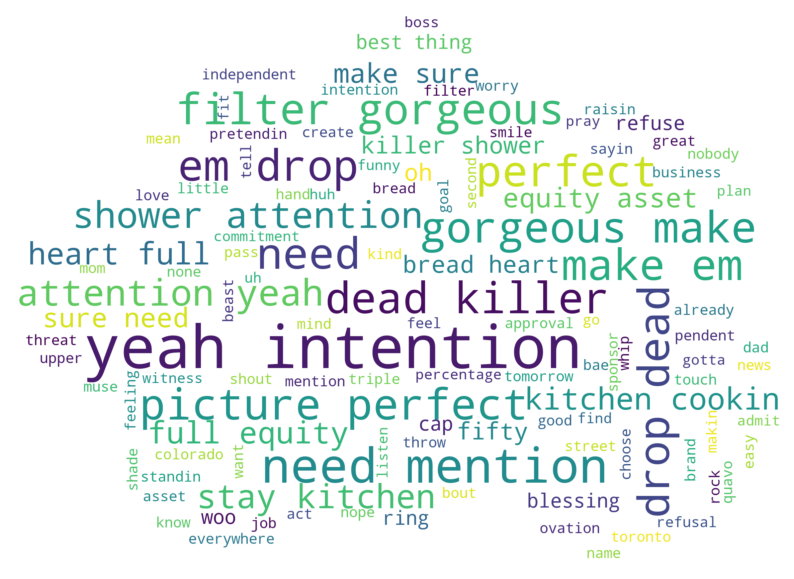

In [891]:
wordcloud_pos = create_wordcloud_from_text(en_positive_list_vader[632])
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_pos, cmap=plt.cm.gray, interpolation="bilinear")
plt.axis('off')
plt.show()


Below is an example of one of the negative word clouds.

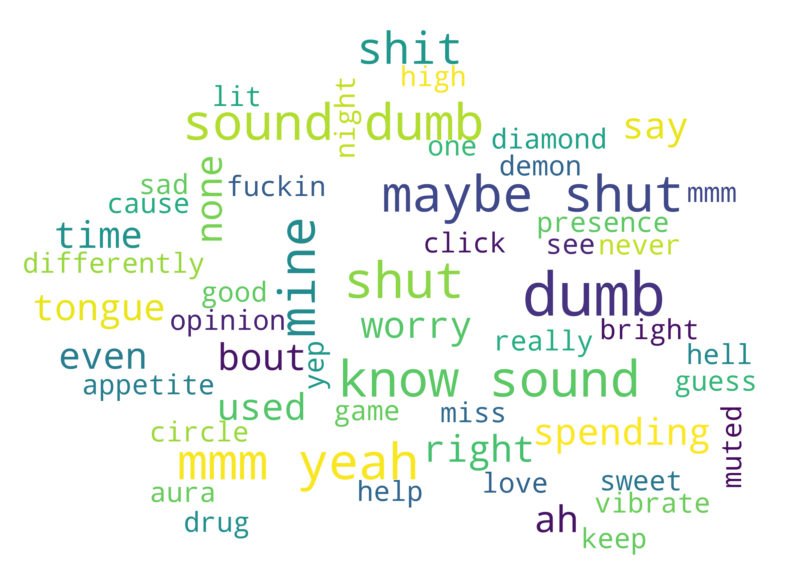

In [894]:
wordcloud_neg = create_wordcloud_from_text(en_negative_list_vader[120])
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_neg, cmap=plt.cm.gray, interpolation="bilinear")
plt.axis('off')
plt.show()
